In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math

In [11]:
class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_heads, num_layers):
    super(Encoder, self).__init__()
    self.embedding = nn.Embedding(input_dim, hidden_dim)
    self.transformer_encoder = nn.TransformerEncoder(
        nn.TransformerEncoderLayer(
            d_model = hidden_dim,
            nhead=num_heads
        ),
        num_layers = num_layers
    )

  def forward(self, src):
    src = self.embedding(src)
    output = self.transformer_encoder(src)
    return output

In [12]:
class Decoder(nn.Module):
  def __init__(self, output_dim, hidden_dim, num_heads, num_layers):
    super(Decoder, self).__init__()
    self.transformer_decoder = nn.TransformerDecoder(
        nn.TransformerDecoderLayer(
            d_model = hidden_dim,
            nhead = num_heads
        ),
        num_layers = num_layers
    )
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, memory, target):
    output = self.transformer_decoder(target, memory)
    output = self.fc(output)
    return output

In [25]:
class MultiheadAttention(nn.Module):
    def __init__(self, hidden_dim, num_heads):
        super(MultiheadAttention, self).__init__()
        self.multihead_attention = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads
        )
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        x = x.permute(1, 0, 2)  # Change the input shape for Multihead Attention
        x, _ = self.multihead_attention(x, x, x)
        x = x.permute(1, 0, 2)  # Reshape it back
        x = x + x  # Residual connection
        x = self.layer_norm(x)
        return x

class Feedforward(nn.Module):
    def __init__(self, hidden_dim, ff_dim):
        super(Feedforward, self).__init__()
        self.feedforward = nn.Sequential(
            nn.Linear(hidden_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, hidden_dim)
        )
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        x = self.feedforward(x)
        x = x + x  # Residual connection
        x = self.layer_norm(x)
        return x

In [26]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_heads, num_layers, ff_dim):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, hidden_dim)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden_dim,
                nhead=num_heads
            ),
            num_layers=num_layers
        )
        self.multihead_attention = MultiheadAttention(hidden_dim, num_heads)
        self.feedforward = Feedforward(hidden_dim, ff_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, src, tgt):
        src = self.embedding(src)
        tgt = self.embedding(tgt)

        encoder_output = self.transformer_encoder(src)
        decoder_input = self.multihead_attention(tgt)
        decoder_output = self.feedforward(decoder_input)

        output = self.fc(decoder_output)
        return output

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/10], Loss: 3.0078
Epoch [2/10], Loss: 2.8897
Epoch [3/10], Loss: 2.5213
Epoch [4/10], Loss: 1.9249
Epoch [5/10], Loss: 1.2183
Epoch [6/10], Loss: 0.7704
Epoch [7/10], Loss: 0.4649
Epoch [8/10], Loss: 0.2762
Epoch [9/10], Loss: 0.1602
Epoch [10/10], Loss: 0.0883


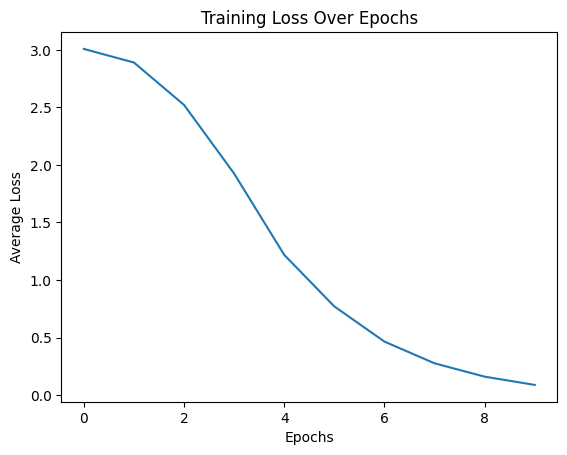

In [30]:
input_dim = 1000
output_dim = 10
train_data = torch.randint(0, input_dim, (1000, 20))  # 예시 데이터
train_labels = torch.randint(0, output_dim, (1000,))

train_dataset = TensorDataset(train_data, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model = TransformerModel(input_dim, output_dim, hidden_dim=64, num_heads=4, num_layers=2, ff_dim=128)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses = []

for epoch in range(10):
    total_loss = 0.0
    for data, labels in train_dataloader:
        optimizer.zero_grad()

        # 모델의 forward 메서드 호출
        outputs = model(data, data)

        # target 크기를 모델 출력과 일치하도록 변경
        labels = labels.unsqueeze(1).expand(-1,10)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)
    losses.append(average_loss)
    print(f'Epoch [{epoch + 1}/10], Loss: {average_loss:.4f}')

plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Training Loss Over Epochs')
plt.show()